<a href="https://colab.research.google.com/github/lniles216/shared_portfolio/blob/main/Income_and_Internet_Provider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Internet Provider Availability and Affordability in NYC

This analysis evaluated internet affordability in NYC

In [ ]:
%%time
# Install rtree - Geopandas requirment
!apt install libspatialindex-dev
!pip install rtree
# Install descartes - Geopandas requirment
!pip install descartes
!pip install geopy
!pip install pygeos

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (700 kB/s)
Selecting previously unselected package libspatialindex

In [ ]:
!pip install --upgrade geopandas
!pip install mapclassify --quiet


     |████████████████████████████████| 1.0MB 6.5MB/s 
     |████████████████████████████████| 15.3MB 459kB/s 
     |████████████████████████████████| 6.5MB 56.8MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

KeyboardInterrupt: ignored

### Download restaurant inspections data

other method is to manually download from the website: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

In [ ]:
!curl https://opendata.fcc.gov/api/views/4kuc-phrr/rows.csv?accessType=DOWNLOAD > Fixed_Broadband_Deployment_Data__June_2020_V1.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.3G    0 10.3G    0     0  5481k      0 --:--:--  0:33:06 --:--:-- 5504k


##FCC Provider

In [ ]:
#Upload data into google collab
from google.colab import files
uploaded = files.upload()

Saving Fixed_Broadband_Deployment_Data__June_2020_V1.csv to Fixed_Broadband_Deployment_Data__June_2020_V1 (1).csv


In [ ]:
import io
fixed_broadband = pd.read_csv(io.BytesIO(uploaded['Fixed_Broadband_Deployment_Data__June_2020_V1.csv'])) # Dataset is now stored in a Pandas Dataframe

In [ ]:
fixed_broadband.head()

,Logical Record Number,Provider ID,FRN,Provider Name,DBA Name,Holding Company Name,Holding Company Number,Holding Company Final,State,Census Block FIPS Code,GEOID_Blockgroup,Technology Code,Consumer,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),Business
0,61382603,71784,12369286,"HNS License Sub, LLC",HughesNet,"Hughes Network Systems, LLC",130627,"Hughes Network Systems, LLC",NY,360450624002080,360450624002,60,1,25.0,3.0,1
1,61583108,71784,12369286,"HNS License Sub, LLC",HughesNet,"Hughes Network Systems, LLC",130627,"Hughes Network Systems, LLC",NY,361070206003067,361070206003,60,1,25.0,3.0,1
2,41262923,74166,25646373,"Charter Communications, Inc.",Charter Communications Inc,Charter Communications,130235,Charter Communications,NY,360470022003009,360470022003,43,1,940.0,35.0,1
3,40141338,74166,25646373,"Charter Communications, Inc.",Charter Communications Inc,Charter Communications,130235,Charter Communications,NY,360010011001089,360010011001,50,1,1000.0,1000.0,0
4,61665229,64685,18756155,"VSAT Systems, LLC","VSAT Systems, LLC","VSAT Systems, LLC",300167,"VSAT Systems, LLC",NY,360191017005003,360191017005,60,1,2.0,1.3,1


In [ ]:
fixed_broadband.dtypes

In [ ]:
len(fixed_broadband)

1048575

In [ ]:
print(fixed_broadband['DBA Name'].value_counts().to_string()) #value counts match up with the previous names

Viasat Inc                                      164657
VSAT Systems, LLC                               157974
HughesNet                                       157399
GCI Communication Corp.                         157152
Verizon New York Inc.                           117010
Charter Communications Inc                       94939
Frontier Communications Corporation              54820
Cablevision                                      32908
Crown Castle Fiber                               28265
Hudson Valley Wireless                            9480
NYSYS Wireless                                    7447
XchangeTelecom                                    4983
Windstream New York Inc.                          4068
Northland Communications                          3600
Consolidated Communications                       2958
Stealth Communications                            2687
Starry, Inc.                                      2620
RCN                                               2608
Westelcom 

#Service Provider Price

In [ ]:
#Upload data into google collab
from google.colab import files
uploaded_5 = files.upload()

Saving ISP_Provider_Costs.csv to ISP_Provider_Costs (1).csv


In [ ]:
import io
provider_price = pd.read_csv(io.BytesIO(uploaded_5['ISP_Provider_Costs.csv'])) # Dataset is now stored in a Pandas Dataframe

In [ ]:
provider_price.dtypes

Service_Provider           object
Lowest_Monthly_Cost_HS    float64
dtype: object

#Household Income Data

In [ ]:
#Upload data into google collab
from google.colab import files
uploaded_2 = files.upload()

Saving ACSDT5Y2019.B19013_data_with_overlays_2021-05-03T205942.csv to ACSDT5Y2019.B19013_data_with_overlays_2021-05-03T205942 (1).csv


In [ ]:
import io
household_income = pd.read_csv(io.BytesIO(uploaded_2['ACSDT5Y2019.B19013_data_with_overlays_2021-05-03T205942.csv'])) # Dataset is now stored in a Pandas Dataframe

In [ ]:
household_income.head()

,GEO_ID,Geographic Area Name,Median_household_income
0,360010001001,"Block Group 1, Census Tract 1, Albany County, ...",44821
1,360010001002,"Block Group 2, Census Tract 1, Albany County, ...",30361
2,360010002001,"Block Group 1, Census Tract 2, Albany County, ...",24271
3,360010002002,"Block Group 2, Census Tract 2, Albany County, ...",43220
4,360010002003,"Block Group 3, Census Tract 2, Albany County, ...",24646


#Census Block Boundaries for NYC

In [ ]:
if not os.path.exists('Data'):
    !mkdir Data
if not os.path.exists('Data/CensusBlocks'):
    !mkdir Data/CensusBlocks

In [ ]:
url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_21a.zip'

urllib.request.urlretrieve(url,'Data/nycb2010_21a.zip')

('Data/nycb2010_21a.zip', <http.client.HTTPMessage at 0x7efc2b84e2d0>)

In [ ]:
import zipfile
with zipfile.ZipFile('Data/nycb2010_21a.zip', 'r') as zip_ref:
    zip_ref.extractall('Data/nycb2010_21a')

In [ ]:
os.listdir('./Data/nycb2010_21a') #check the filename for the shapefile

['nycb2010_21a']

In [ ]:
#load the resulting shapefile using geopandas
nycb2010_shape = gpd.read_file('./Data/nycb2010_21a/nycb2010_21a/nycb2010.shp')
nycb2010_shape.head()

,CB2010,BoroCode,BoroName,CT2010,BCTCB2010,Shape_Leng,Shape_Area,geometry
0,1000,5,Staten Island,000900,50009001000,2508.948115,244589.603884,"POLYGON ((962269.126 173705.500, 962288.722 17..."
1,1000,5,Staten Island,002001,50020011000,1345.886422,111006.286826,"POLYGON ((964642.268 161835.265, 964359.942 16..."
2,1000,5,Staten Island,002700,50027001000,1703.381172,150406.766022,"POLYGON ((963363.117 167356.334, 962737.737 16..."
3,1000,5,Staten Island,004000,50040001000,1511.173743,141296.561149,"POLYGON ((960069.997 161953.694, 959831.480 16..."
4,1000,5,Staten Island,006400,50064001000,1978.243852,200784.983607,"POLYGON ((963023.892 158246.752, 962949.824 15..."


#Block Group Shapefile

In [ ]:
from google.colab import files
uploaded_3 = files.upload()

Saving tl_2020_36_bg.zip to tl_2020_36_bg (1).zip


In [ ]:
import zipfile
with zipfile.ZipFile('tl_2020_36_bg.zip', 'r') as zip_ref:
    zip_ref.extractall('Data/tl_2020_36_bg')

In [ ]:
os.listdir('./Data/nycb2010_21a') #check the filename for the shapefile

['nycb2010_21a']

In [ ]:
#load the resulting shapefile using geopandas
census_nysb2020_shape = gpd.read_file('./Data/tl_2020_36_bg/tl_2020_36_bg.shp')
census_nysb2020_shape.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,019,101000,3,360191010003,Block Group 3,G5030,S,363407,0,+44.6938385,-073.4714736,"POLYGON ((-73.47596 44.69761, -73.47489 44.697..."
1,36,019,100200,1,360191002001,Block Group 1,G5030,S,57385113,312716,+44.8827953,-073.4907087,"POLYGON ((-73.55525 44.87744, -73.55521 44.878..."
2,36,019,102200,3,360191022003,Block Group 3,G5030,S,585561,0,+44.6798483,-073.4557185,"POLYGON ((-73.46084 44.68186, -73.46079 44.682..."
3,36,019,100800,2,360191008002,Block Group 2,G5030,S,2482325,0,+44.7175166,-073.5029347,"POLYGON ((-73.52782 44.71511, -73.52781 44.715..."
4,36,029,009008,2,360290090082,Block Group 2,G5030,S,925805,0,+42.9964244,-078.7241334,"POLYGON ((-78.73283 42.99889, -78.73243 42.998..."


In [ ]:
len(census_nysb2020_shape)

16070

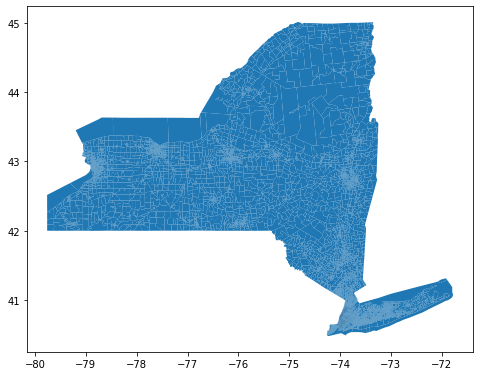

In [ ]:
census_nysb2020_shape.plot(figsize=(8,8))

In [ ]:
nyc_COUNTYFP = ['005','047','061','081','085']

In [ ]:
print(census_nysb2020_shape['COUNTYFP'].value_counts().to_string()) #value counts match up with the previous names

047    2156
081    1803
061    1292
005    1182
059    1139
103    1058
029     813
119     725
055     597
067     392
085     374
071     292
027     255
001     238
087     223
007     197
065     193
063     175
091     169
111     155
093     142
083     126
013     125
089     106
045     101
069      95
075      95
101      94
105      89
015      86
009      80
011      80
019      78
079      74
109      65
043      64
021      64
117      64
035      60
113      60
077      59
025      55
115      53
017      52
037      51
053      50
051      49
003      48
023      47
039      46
107      45
031      44
057      43
033      42
121      38
095      33
073      33
099      32
123      25
049      22
097      19
041       8


#Join Shape Files

In [ ]:
nyc_geoid_shape_test = census_nysb2020_shape.loc[census_nysb2020_shape['COUNTYFP'].isin(nyc_COUNTYFP)]

In [ ]:
nyc_geoid_shape_test.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
24,36,061,023900,1,360610239001,Block Group 1,G5030,S,27517,0,+40.8322236,-073.9404112,"POLYGON ((-73.94112 40.83166, -73.94088 40.832..."
25,36,061,013900,1,360610139001,Block Group 1,G5030,S,23621,0,+40.7688543,-073.9868884,"POLYGON ((-73.98806 40.76979, -73.98666 40.769..."
26,36,061,007800,2,360610078002,Block Group 2,G5030,S,33890,0,+40.7471571,-073.9756186,"POLYGON ((-73.97673 40.74763, -73.97635 40.748..."
27,36,061,008900,1,360610089001,Block Group 1,G5030,S,20377,0,+40.7443158,-074.0010568,"POLYGON ((-74.00226 40.74521, -73.99942 40.744..."
28,36,061,008900,4,360610089004,Block Group 4,G5030,S,42006,0,+40.7458221,-074.0036736,"POLYGON ((-74.00511 40.74640, -74.00465 40.747..."


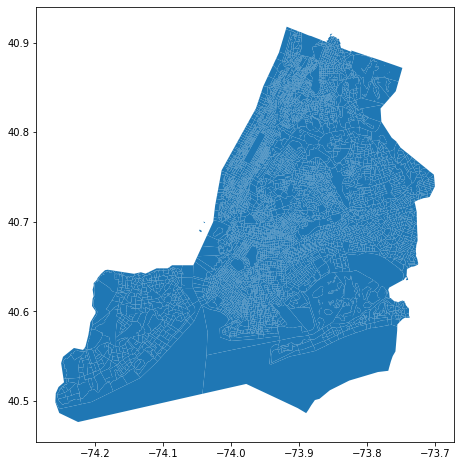

In [ ]:
nyc_geoid_shape_test.plot(figsize=(8,8))

In [ ]:
nyc_geoid_shape_test.dtypes

STATEFP       object
COUNTYFP      object
TRACTCE       object
BLKGRPCE      object
GEOID         object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [ ]:
nyc_geoid_shape_test['GEOID'] = nyc_geoid_shape_test.GEOID.astype(int)

In [ ]:
nyc_geoid_shape_test.dtypes

STATEFP       object
COUNTYFP      object
TRACTCE       object
BLKGRPCE      object
GEOID          int64
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [ ]:
len(nyc_geoid_shape_test)

6807

#FCC Providers for NYC

In [ ]:
len(fixed_broadband)

1048575

In [ ]:
len(fixed_broadband[~fixed_broadband.GEOID_Blockgroup.isin(nyc_geoid_shape_test.GEOID)])

917693

In [ ]:
fixed_broadband_nyc = fixed_broadband[fixed_broadband.GEOID_Blockgroup.isin(nyc_geoid_shape_test.GEOID)]
fixed_broadband_nyc.shape

(130882, 16)

In [ ]:
len(fixed_broadband_nyc)

130882

In [ ]:
fixed_broadband_nyc.head()

,Logical Record Number,Provider ID,FRN,Provider Name,DBA Name,Holding Company Name,Holding Company Number,Holding Company Final,State,Census Block FIPS Code,GEOID_Blockgroup,Technology Code,Consumer,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),Business
2,41262923,74166,25646373,"Charter Communications, Inc.",Charter Communications Inc,Charter Communications,130235,Charter Communications,NY,360470022003009,360470022003,43,1,940.0,35.0,1
10,15264007,65430,19027440,CSC Holdings LLC,Cablevision,Altice,130370,Altice,NY,360050153001008,360050153001,43,1,1000.0,1000.0,1
14,17859180,68601,3469442,Verizon New York Inc.,Verizon New York Inc.,Verizon Communications Inc.,131425,Verizon Communications Inc.,NY,360810551002002,360810551002,50,1,940.0,880.0,1
17,61296802,71784,12369286,"HNS License Sub, LLC",HughesNet,"Hughes Network Systems, LLC",130627,"Hughes Network Systems, LLC",NY,360050211001001,360050211001,60,1,25.0,3.0,1
33,17859552,68601,3469442,Verizon New York Inc.,Verizon New York Inc.,Verizon Communications Inc.,131425,Verizon Communications Inc.,NY,360810531003004,360810531003,50,1,940.0,880.0,1


In [ ]:
top_residential_providers = ['Verizon New York Inc.', 'Viasat Inc', 'VSAT Systems, LLC', 'HughesNet', 'GCI Communication Corp.', 'Charter Communications Inc', 'Cablevision']

In [ ]:
print(fixed_broadband_nyc['DBA Name'].value_counts().to_string()) #value counts match up with the previous names

Verizon New York Inc.                  26421
Viasat Inc                             16287
VSAT Systems, LLC                      16228
HughesNet                              16106
GCI Communication Corp.                16035
Charter Communications Inc             10935
Crown Castle Fiber                      7597
Cablevision                             4474
XchangeTelecom                          4256
Stealth Communications                  2505
Starry, Inc.                            2388
RCN                                     2261
Nuvisions                               1705
MCI                                      627
Lightpath                                579
PAETEC Communications, Inc               445
CenturyLink                              339
Broadview Networks Holdings, Inc.        303
Towerstream                              269
XO Communications                        217
EarthLink Business, LLC                  148
Consolidated Communications              144
Pilot     

In [ ]:
len(fixed_broadband_nyc['DBA Name'].unique())

60

In [ ]:
top_fixed_broadband_nyc = fixed_broadband_nyc.loc[fixed_broadband_nyc['DBA Name'].isin(top_residential_providers)]

In [ ]:
len(top_fixed_broadband_nyc)

106486

In [ ]:
print(top_fixed_broadband_nyc['DBA Name'].value_counts().to_string())

Verizon New York Inc.         26421
Viasat Inc                    16287
VSAT Systems, LLC             16228
HughesNet                     16106
GCI Communication Corp.       16035
Charter Communications Inc    10935
Cablevision                    4474


In [ ]:
top_fixed_broadband_nyc['DBA Name'].unique()

array(['Charter Communications Inc', 'Cablevision',
       'Verizon New York Inc.', 'HughesNet', 'GCI Communication Corp.',
       'VSAT Systems, LLC', 'Viasat Inc'], dtype=object)

In [ ]:
top_fixed_broadband_nyc['DBA Name'] = top_fixed_broadband_nyc['DBA Name'].replace(('Charter Communications Inc', 'VSAT Systems, LLC'), ('Spectrum', 'HughesNet'))

In [ ]:
print(top_fixed_broadband_nyc['DBA Name'].value_counts().to_string())

HughesNet                  32334
Verizon New York Inc.      26421
Viasat Inc                 16287
GCI Communication Corp.    16035
Spectrum                   10935
Cablevision                 4474


In [ ]:
top_fixed_broadband_nyc.head()

,Logical Record Number,Provider ID,FRN,Provider Name,DBA Name,Holding Company Name,Holding Company Number,Holding Company Final,State,Census Block FIPS Code,GEOID_Blockgroup,Technology Code,Consumer,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),Business
2,41262923,74166,25646373,"Charter Communications, Inc.",Spectrum,Charter Communications,130235,Charter Communications,NY,360470022003009,360470022003,43,1,940.0,35.0,1
10,15264007,65430,19027440,CSC Holdings LLC,Cablevision,Altice,130370,Altice,NY,360050153001008,360050153001,43,1,1000.0,1000.0,1
14,17859180,68601,3469442,Verizon New York Inc.,Verizon New York Inc.,Verizon Communications Inc.,131425,Verizon Communications Inc.,NY,360810551002002,360810551002,50,1,940.0,880.0,1
17,61296802,71784,12369286,"HNS License Sub, LLC",HughesNet,"Hughes Network Systems, LLC",130627,"Hughes Network Systems, LLC",NY,360050211001001,360050211001,60,1,25.0,3.0,1
33,17859552,68601,3469442,Verizon New York Inc.,Verizon New York Inc.,Verizon Communications Inc.,131425,Verizon Communications Inc.,NY,360810531003004,360810531003,50,1,940.0,880.0,1


In [ ]:
top_fixed_broadband_nyc_price = top_fixed_broadband_nyc.merge(provider_price, left_on='DBA Name', right_on='Service_Provider')

In [ ]:
top_fixed_broadband_nyc_price.head()

,Logical Record Number,Provider ID,FRN,Provider Name,DBA Name,Holding Company Name,Holding Company Number,Holding Company Final,State,Census Block FIPS Code,GEOID_Blockgroup,Technology Code,Consumer,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),Business,Service_Provider,Lowest_Monthly_Cost_HS
0,41262923,74166,25646373,"Charter Communications, Inc.",Spectrum,Charter Communications,130235,Charter Communications,NY,360470022003009,360470022003,43,1,940.0,35.0,1,Spectrum,50.0
1,41332005,74166,25646373,"Charter Communications, Inc.",Spectrum,Charter Communications,130235,Charter Communications,NY,360810383021202,360810383021,43,1,940.0,35.0,1,Spectrum,50.0
2,41327301,74166,25646373,"Charter Communications, Inc.",Spectrum,Charter Communications,130235,Charter Communications,NY,360810012001003,360810012001,43,1,940.0,35.0,1,Spectrum,50.0
3,41346365,74166,25646373,"Charter Communications, Inc.",Spectrum,Charter Communications,130235,Charter Communications,NY,360850008002005,360850008002,43,1,940.0,35.0,1,Spectrum,50.0
4,41262804,74166,25646373,"Charter Communications, Inc.",Spectrum,Charter Communications,130235,Charter Communications,NY,360470054002001,360470054002,43,1,940.0,35.0,1,Spectrum,50.0


In [ ]:
top_fixed_broadband_nyc_costs = top_fixed_broadband_nyc_price.groupby('GEOID_Blockgroup').agg({'Lowest_Monthly_Cost_HS': ['mean', 'min', 'max']})
top_fixed_broadband_nyc_costs.columns = ['monthly_mean', 'monthly_min', 'monthly_max']
top_fixed_broadband_nyc_costs = top_fixed_broadband_nyc_costs.reset_index()

In [ ]:
top_fixed_broadband_nyc_costs['annual_cost_isp'] = top_fixed_broadband_nyc_costs['monthly_mean']*12

In [ ]:
top_fixed_broadband_nyc_costs.sort_values(by ='monthly_mean', ascending=False).head(10)

,GEOID_Blockgroup,monthly_mean,monthly_min,monthly_max,annual_cost_isp
0,360050001000,100.0,100.0,100.0,1200.0
3363,360610106020,100.0,100.0,100.0,1200.0
2997,360479901000,100.0,100.0,100.0,1200.0
3010,360610006000,100.0,100.0,100.0,1200.0
3030,360610010020,100.0,100.0,100.0,1200.0
3046,360610015020,100.0,100.0,100.0,1200.0
3073,360610025000,100.0,100.0,100.0,1200.0
3228,360610069000,100.0,100.0,100.0,1200.0
3268,360610079000,100.0,100.0,100.0,1200.0
3280,360610081003,100.0,100.0,100.0,1200.0


####Provider Group By

####Continuation from before.

In [ ]:
top_fixed_broadband_nyc_costs.dtypes

GEOID_Blockgroup      int64
monthly_mean        float64
monthly_min         float64
monthly_max         float64
annual_cost_isp     float64
dtype: object

In [ ]:
top_fixed_broadband_nyc_costs_nowater = top_fixed_broadband_nyc_costs[top_fixed_broadband_nyc_costs.GEOID_Blockgroup.isin(household_income.GEO_ID)]

In [ ]:
top_fixed_broadband_nyc_costs_shape = nyc_geoid_shape_test.merge(top_fixed_broadband_nyc_costs, left_on='GEOID', right_on='GEOID_Blockgroup')

In [ ]:
top_fixed_broadband_nyc_costs_shape.plot(figsize=(10,10), column='monthly_mean', scheme='Quantiles', k=10, legend=True)

NameError: ignored

In [ ]:
if not os.path.exists('Data'):
    !mkdir Data
if not os.path.exists('Data/ZIPCODE'):
    !mkdir Data/RollingSale

In [ ]:
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'

urllib.request.urlretrieve(url,'Data/ZIPCODE.zip')

In [ ]:
import zipfile
with zipfile.ZipFile('Data/ZIPCODE.zip', 'r') as zip_ref:
    zip_ref.extractall('Data/ZIPCODE')

In [ ]:
## zip codes map
zips = gpd.read_file('./Data/ZIPCODE/ZIP_CODE_040114.shp')
zips.plot(figsize=(8,8))

In [ ]:
#print("top_fixed_broadband_nyc_costs_shape", top_fixed_broadband_nyc_costs_shape.crs)
#print("zips", zips.crs)

In [ ]:
#top_fixed_broadband_nyc_2263 = gpd.GeoDataFrame(top_fixed_broadband_nyc_costs_shape,
                              # crs={'init': 'epsg:2263'})

In [ ]:
#top_fixed_broadband_nyc_2263.head

In [ ]:
#top_fixed_broadband_nyc_2263.crs

In [ ]:
# Load the box module from shapely to create box objects
#from shapely.geometry import box
#import seaborn as sns

In [ ]:
top_fixed_broadband_nyc_costs_shape.head()

NameError: ignored

#Join Income and Fixed Broadband

In [ ]:
income_internet = top_fixed_broadband_nyc_costs_shape.merge(household_income, left_on='GEOID_Blockgroup', right_on='GEO_ID')

In [ ]:
income_internet['Median_household_income'] = pd.to_numeric(income_internet['Median_household_income'], errors ='coerce')

In [ ]:
income_internet.dtypes

STATEFP                      object
COUNTYFP                     object
TRACTCE                      object
BLKGRPCE                     object
GEOID                         int64
NAMELSAD                     object
MTFCC                        object
FUNCSTAT                     object
ALAND                         int64
AWATER                        int64
INTPTLAT                     object
INTPTLON                     object
geometry                   geometry
GEOID_Blockgroup              int64
monthly_mean                float64
monthly_min                 float64
monthly_max                 float64
annual_cost_isp             float64
GEO_ID                        int64
Geographic Area Name         object
Median_household_income     float64
dtype: object

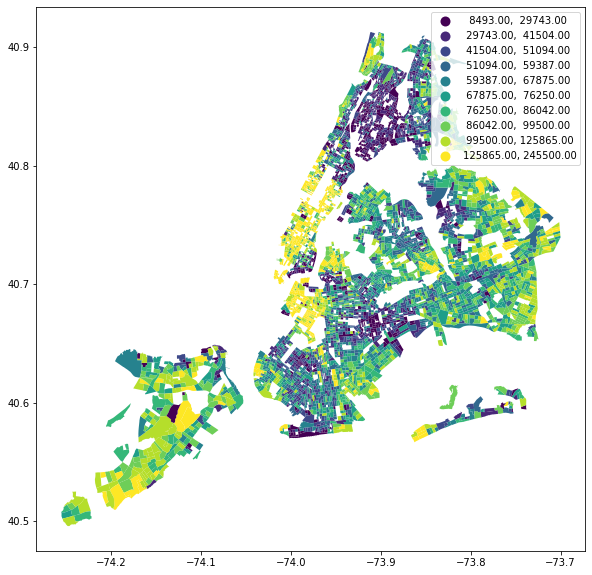

In [ ]:
income_internet.plot(figsize=(10,10), column='Median_household_income', scheme='Quantiles', k=10, legend=True)

In [ ]:
income_internet['percent_of_income'] = income_internet['annual_cost_isp']/income_internet['Median_household_income']

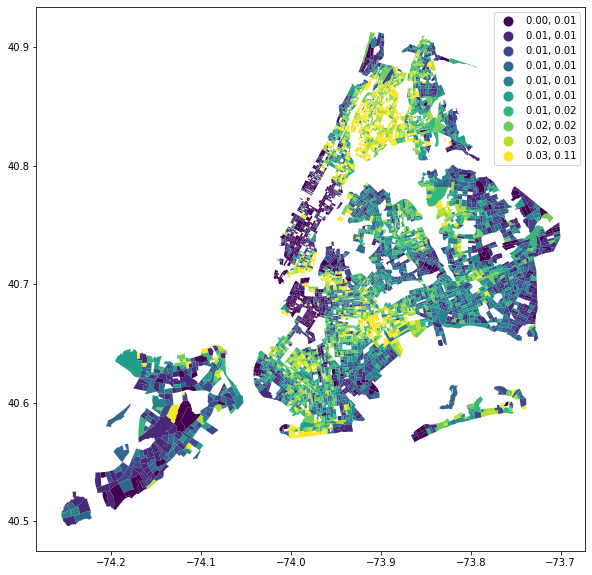

In [ ]:
income_internet.plot(figsize=(10,10), column='percent_of_income', scheme='Quantiles', k=10, legend=True)

In [ ]:
income_internet.isna().sum()

STATEFP                      0
COUNTYFP                     0
TRACTCE                      0
BLKGRPCE                     0
GEOID                        0
NAMELSAD                     0
MTFCC                        0
FUNCSTAT                     0
ALAND                        0
AWATER                       0
INTPTLAT                     0
INTPTLON                     0
geometry                     0
GEOID_Blockgroup             0
monthly_mean                 0
monthly_min                  0
monthly_max                  0
annual_cost_isp              0
GEO_ID                       0
Geographic Area Name         0
Median_household_income    615
percent_of_income          615
dtype: int64

In [ ]:
len(income_internet)

5866

In [ ]:
#condensed_columns = ['Geographic Area Name', 'Median_household_income', 'Provider ID', 'Provider Name','DBA Name', 'Census Block FIPS Code','Technology Code', 'Max Advertised Downstream Speed (mbps)', 'Max Advertised Upstream Speed (mbps)','GEO_ID']
#income_internet_condensed = income_internet[condensed_columns]

KeyError: ignored

In [ ]:
income_internet_condensed.head()

NameError: ignored

In [ ]:
income_internet_condensed.dtypes

Geographic Area Name                       object
Median_household_income                    object
Provider ID                                 int64
Provider Name                              object
DBA Name                                   object
Census Block FIPS Code                      int64
Technology Code                             int64
Max Advertised Downstream Speed (mbps)    float64
Max Advertised Upstream Speed (mbps)      float64
GEO_ID                                      int64
dtype: object

In [ ]:
income_internet_condensed['Median_household_income'] = pd.to_numeric(income_internet_condensed['Median_household_income'], errors ='coerce')

In [ ]:
income_internet_condensed.dtypes

Geographic Area Name                       object
Median_household_income                   float64
Provider ID                                 int64
Provider Name                              object
DBA Name                                   object
Census Block FIPS Code                      int64
Technology Code                             int64
Max Advertised Downstream Speed (mbps)    float64
Max Advertised Upstream Speed (mbps)      float64
GEO_ID                                      int64
dtype: object

In [ ]:
income_internet_condensed.head()

,Geographic Area Name,Median_household_income,Provider ID,Provider Name,DBA Name,Census Block FIPS Code,Technology Code,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),GEO_ID
0,"Block Group 1, Census Tract 1, Albany County, ...",44821.0,69187,"ViaSat, Inc.",Viasat Inc,360010001001026,60,35.0,3.0,360010001001
1,"Block Group 1, Census Tract 1, Albany County, ...",44821.0,64685,"VSAT Systems, LLC","VSAT Systems, LLC",360010001001010,60,2.0,1.3,360010001001
2,"Block Group 1, Census Tract 1, Albany County, ...",44821.0,74166,"Charter Communications, Inc.",Charter Communications Inc,360010001001005,43,940.0,35.0,360010001001
3,"Block Group 1, Census Tract 1, Albany County, ...",44821.0,74376,GCI Communication Corp.,GCI Communication Corp.,360010001001019,60,0.0,0.0,360010001001
4,"Block Group 1, Census Tract 1, Albany County, ...",44821.0,69187,"ViaSat, Inc.",Viasat Inc,360010001001059,60,35.0,3.0,360010001001


In [ ]:
len(income_internet_condensed)

1041836

In [ ]:
print(income_internet_condensed['GEO_ID'].value_counts().to_string()) #value counts match up with the previous names

360430115021    1031
360510313002     826
360459800001     800
360499507003     786
360319614002     772
360419501001     770
360999508002     700
360894925004     682
360430109002     661
360650241011     659
361031470041     650
360130366002     622
361231501001     621
360710136001     618
360499501002     617
360750203022     580
360450625002     576
360419505001     575
360259714001     574
361059523001     570
360999501001     564
360099613004     562
360010011001     553
360290165001     551
360339507002     551
360499504001     545
360750201001     544
360510308001     536
360419505002     534
360010137031     526
360259713001     525
360450608046     523
360259705003     522
360830526012     509
361170217002     508
360979502002     507
360810383021     505
361130740001     501
360750202001     499
360499502002     499
360894926004     499
360319609003     498
360259703003     498
360650243031     498
360510302012     497
360179701001     493
360499505002     492
360910605011 

In [ ]:
print(income_internet_condensed['Provider Name'].value_counts().to_string()) #value counts match up with the previous names

ViaSat, Inc.                                                                                                                   163534
VSAT Systems, LLC                                                                                                              156892
HNS License Sub, LLC                                                                                                           156347
GCI Communication Corp.                                                                                                        156039
Verizon New York Inc.                                                                                                          116469
Charter Communications, Inc.                                                                                                    93978
Frontier Communications Corporation                                                                                             54734
CSC Holdings LLC                                              

In [ ]:
medianincome_geoid = income_internet_condensed.groupby(['GEO_ID'], as_index=False).agg({'Provider Name':'count','Median_household_income':'mean' })

In [ ]:
medianincome_geoid.head()

,GEO_ID,Provider Name,Median_household_income
0,360010001001,199,44821.0
1,360010001002,39,30361.0
2,360010002001,176,24271.0
3,360010002002,40,43220.0
4,360010002003,34,24646.0


In [ ]:
medianincome_provider = income_internet_condensed.groupby(['Provider Name'], as_index=False).agg({'Median_household_income':'mean' })

In [ ]:
medianincome_provider.head()

,Provider Name,Median_household_income
0,1970,108167.000000
1,"ANPI Business, LLC",89043.666667
2,Adams CATV Inc.,54149.290598
3,"Advanced Corporate Networking, Inc.",69041.400000
4,"Allied Telecom Group, LLC",157559.666667


In [ ]:
type1_crimes_geoByDate = type1_crimes_geo.groupby(['CMPLNT_FR_DT'], as_index=False).agg({'CMPLNT_NUM':'count'})


#Spatial and Data Join

In [ ]:
income_internet_condensed_shape = income_internet_condensed.merge(nyc_geoid_shape_test, left_on='GEO_ID', right_on='GEOID')

In [ ]:
income_internet_condensed_shape.head(20)

,Geographic Area Name,Median_household_income,Provider ID,Provider Name,DBA Name,Census Block FIPS Code,Technology Code,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),GEO_ID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,"Block Group 0, Census Tract 1, Bronx County, N...",-,69187,"ViaSat, Inc.",Viasat Inc,360050001000001,60,35.0,3.0,360050001000,36,005,000100,0,360050001000,Block Group 0,G5030,S,0,1035011,+40.7981690,-073.8916815,"POLYGON ((-73.89772 40.79514, -73.89611 40.796..."
1,"Block Group 0, Census Tract 1, Bronx County, N...",-,69187,"ViaSat, Inc.",Viasat Inc,360050001000002,60,35.0,3.0,360050001000,36,005,000100,0,360050001000,Block Group 0,G5030,S,0,1035011,+40.7981690,-073.8916815,"POLYGON ((-73.89772 40.79514, -73.89611 40.796..."
2,"Block Group 1, Census Tract 1, Bronx County, N...",-,61558,"RCN Telecom Services of New York, LP",RCN,360050001001002,42,500.0,20.0,360050001001,36,005,000100,1,360050001001,Block Group 1,G5030,S,1677210,0,+40.7911136,-073.8826858,"POLYGON ((-73.89266 40.79382, -73.89194 40.796..."
3,"Block Group 1, Census Tract 1, Bronx County, N...",-,64685,"VSAT Systems, LLC","VSAT Systems, LLC",360050001001006,60,2.0,1.3,360050001001,36,005,000100,1,360050001001,Block Group 1,G5030,S,1677210,0,+40.7911136,-073.8826858,"POLYGON ((-73.89266 40.79382, -73.89194 40.796..."
4,"Block Group 1, Census Tract 1, Bronx County, N...",-,69187,"ViaSat, Inc.",Viasat Inc,360050001001000,60,35.0,3.0,360050001001,36,005,000100,1,360050001001,Block Group 1,G5030,S,1677210,0,+40.7911136,-073.8826858,"POLYGON ((-73.89266 40.79382, -73.89194 40.796..."
5,"Block Group 1, Census Tract 1, Bronx County, N...",-,71784,"HNS License Sub, LLC",HughesNet,360050001001008,60,25.0,3.0,360050001001,36,005,000100,1,360050001001,Block Group 1,G5030,S,1677210,0,+40.7911136,-073.8826858,"POLYGON ((-73.89266 40.79382, -73.89194 40.796..."
6,"Block Group 1, Census Tract 1, Bronx County, N...",-,64685,"VSAT Systems, LLC","VSAT Systems, LLC",360050001001000,60,2.0,1.3,360050001001,36,005,000100,1,360050001001,Block Group 1,G5030,S,1677210,0,+40.7911136,-073.8826858,"POLYGON ((-73.89266 40.79382, -73.89194 40.796..."
7,"Block Group 1, Census Tract 1, Bronx County, N...",-,69187,"ViaSat, Inc.",Viasat Inc,360050001001002,60,35.0,3.0,360050001001,36,005,000100,1,360050001001,Block Group 1,G5030,S,1677210,0,+40.7911136,-073.8826858,"POLYGON ((-73.89266 40.79382, -73.89194 40.796..."
8,"Block Group 1, Census Tract 1, Bronx County, N...",-,74376,GCI Communication Corp.,GCI Communication Corp.,360050001001000,60,0.0,0.0,360050001001,36,005,000100,1,360050001001,Block Group 1,G5030,S,1677210,0,+40.7911136,-073.8826858,"POLYGON ((-73.89266 40.79382, -73.89194 40.796..."
9,"Block Group 1, Census Tract 1, Bronx County, N...",-,69187,"ViaSat, Inc.",Viasat Inc,360050001001012,60,35.0,3.0,360050001001,36,005,000100,1,360050001001,Block Group 1,G5030,S,1677210,0,+40.7911136,-073.8826858,"POLYGON ((-73.89266 40.79382, -73.89194 40.796..."


In [ ]:
income_internet_condensed_shape.dtypes

Geographic Area Name                        object
Median_household_income                     object
Provider ID                                  int64
Provider Name                               object
DBA Name                                    object
Census Block FIPS Code                       int64
Technology Code                              int64
Max Advertised Downstream Speed (mbps)     float64
Max Advertised Upstream Speed (mbps)       float64
GEO_ID                                       int64
STATEFP                                     object
COUNTYFP                                    object
TRACTCE                                     object
BLKGRPCE                                    object
GEOID                                        int64
NAMELSAD                                    object
MTFCC                                       object
FUNCSTAT                                    object
ALAND                                        int64
AWATER                         